**Install kagglehub + imports**

In [1]:
# ---------- COLAB STABLE SCIENTIFIC STACK (NO ABI/ATTR ERRORS) ----------
!pip -q install --upgrade --force-reinstall \
  "numpy==2.0.2" \
  "pandas==2.2.2" \
  "scipy==1.14.1" \
  "scikit-learn==1.5.2" \
  "requests==2.32.4" \
  "pydantic==2.12.3" \
  "opencv-python-headless==4.12.0.88" \
  "albumentations==2.0.8" \
  "kagglehub"

# (Optional but recommended) Remove numba if it still complains and you don't need it
!pip -q uninstall -y numba || true

# ---------- IMPORTS ----------
import os, glob, random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import kagglehub

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("scikit-learn:", __import__("sklearn").__version__)
print("scipy:", __import__("scipy").__version__)
print("opencv:", cv2.__version__)
print("albumentations:", A.__version__)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 125.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 137.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 149.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip -q uninstall -y umap-learn hdbscan || true

**KaggleHub dataset download**

In [3]:
# Download dataset using kagglehub (as shown on Kaggle website)
dataset_path = kagglehub.dataset_download("briscdataset/brisc2025")

print("Dataset downloaded to:")
print(dataset_path)


Using Colab cache for faster access to the 'brisc2025' dataset.
Dataset downloaded to:
/kaggle/input/brisc2025


**Inspect dataset structure**

In [4]:
# Inspect dataset directory structure
for root, dirs, files in os.walk(dataset_path):
    print(root)
    for d in dirs:
        print("  DIR :", d)
    for f in files[:5]:
        print("  FILE:", f)
    print("-"*40)


/kaggle/input/brisc2025
  DIR : brisc2025
----------------------------------------
/kaggle/input/brisc2025/brisc2025
  DIR : segmentation_task
  DIR : classification_task
  FILE: manifest.json
  FILE: README.md
  FILE: manifest.csv
  FILE: manifest.json.sha256
  FILE: manifest.csv.sha256
----------------------------------------
/kaggle/input/brisc2025/brisc2025/segmentation_task
  DIR : test
  DIR : train
----------------------------------------
/kaggle/input/brisc2025/brisc2025/segmentation_task/test
  DIR : images
  DIR : masks
----------------------------------------
/kaggle/input/brisc2025/brisc2025/segmentation_task/test/images
  FILE: brisc2025_test_00560_me_sa_t1.jpg
  FILE: brisc2025_test_00949_pi_sa_t1.jpg
  FILE: brisc2025_test_00177_gl_sa_t1.jpg
  FILE: brisc2025_test_00799_pi_ax_t1.jpg
  FILE: brisc2025_test_00705_pi_ax_t1.jpg
----------------------------------------
/kaggle/input/brisc2025/brisc2025/segmentation_task/test/masks
  FILE: brisc2025_test_00855_pi_co_t1.png
  F

**Define paths**

In [5]:

DATA_ROOT = os.path.join(dataset_path, "brisc2025")

# -------- Segmentation task paths --------
SEG_ROOT = os.path.join(DATA_ROOT, "segmentation_task")

SEG_TRAIN_IMG_DIR  = os.path.join(SEG_ROOT, "train", "images")
SEG_TRAIN_MASK_DIR = os.path.join(SEG_ROOT, "train", "masks")

SEG_TEST_IMG_DIR   = os.path.join(SEG_ROOT, "test", "images")
SEG_TEST_MASK_DIR  = os.path.join(SEG_ROOT, "test", "masks")

# -------- Classification task paths --------
CLS_ROOT = os.path.join(DATA_ROOT, "classification_task")

CLS_TRAIN_DIR = os.path.join(CLS_ROOT, "train")  # contains folders: glioma/meningioma/no_tumor/pituitary
CLS_TEST_DIR  = os.path.join(CLS_ROOT, "test")   # contains folders: glioma/meningioma/no_tumor/pituitary

# -------- Sanity checks --------
for p in [
    DATA_ROOT,
    SEG_TRAIN_IMG_DIR, SEG_TRAIN_MASK_DIR,
    SEG_TEST_IMG_DIR,  SEG_TEST_MASK_DIR,
    CLS_TRAIN_DIR, CLS_TEST_DIR
]:
    assert os.path.exists(p), f"Missing path: {p}"

print("DATA_ROOT:", DATA_ROOT)

print("\n[Segmentation]")
print(" Train images:", SEG_TRAIN_IMG_DIR, " count:", len(glob.glob(os.path.join(SEG_TRAIN_IMG_DIR, '*'))))
print(" Train masks :", SEG_TRAIN_MASK_DIR, " count:", len(glob.glob(os.path.join(SEG_TRAIN_MASK_DIR, '*'))))
print(" Test images :", SEG_TEST_IMG_DIR,  " count:", len(glob.glob(os.path.join(SEG_TEST_IMG_DIR, '*'))))
print(" Test masks  :", SEG_TEST_MASK_DIR, " count:", len(glob.glob(os.path.join(SEG_TEST_MASK_DIR, '*'))))

print("\n[Classification]")
print(" Train dir:", CLS_TRAIN_DIR, " classes:", sorted([d for d in os.listdir(CLS_TRAIN_DIR) if os.path.isdir(os.path.join(CLS_TRAIN_DIR,d))]))
print(" Test dir :", CLS_TEST_DIR,  " classes:", sorted([d for d in os.listdir(CLS_TEST_DIR)  if os.path.isdir(os.path.join(CLS_TEST_DIR,d))]))


DATA_ROOT: /kaggle/input/brisc2025/brisc2025

[Segmentation]
 Train images: /kaggle/input/brisc2025/brisc2025/segmentation_task/train/images  count: 3933
 Train masks : /kaggle/input/brisc2025/brisc2025/segmentation_task/train/masks  count: 3933
 Test images : /kaggle/input/brisc2025/brisc2025/segmentation_task/test/images  count: 860
 Test masks  : /kaggle/input/brisc2025/brisc2025/segmentation_task/test/masks  count: 860

[Classification]
 Train dir: /kaggle/input/brisc2025/brisc2025/classification_task/train  classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
 Test dir : /kaggle/input/brisc2025/brisc2025/classification_task/test  classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


**Build Segmentation DataFrame (train + test) by matching image ↔ mask**

In [6]:
# =========================
# Cell 5: Build Segmentation DataFrames (train/test)
# =========================

def list_files(folder, exts=(".jpg", ".jpeg", ".png")):
    files = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(folder, f"*{ext}")))
    return sorted(files)

def build_seg_df(img_dir, mask_dir, split_name):
    img_files = list_files(img_dir, exts=(".jpg", ".jpeg"))
    mask_files = list_files(mask_dir, exts=(".png", ".jpg", ".jpeg"))

    # map mask by "image_id" (filename without extension)
    mask_map = {os.path.splitext(os.path.basename(p))[0]: p for p in mask_files}

    rows = []
    missing_masks = 0

    for img_path in img_files:
        image_id = os.path.splitext(os.path.basename(img_path))[0]
        mask_path = mask_map.get(image_id, None)
        if mask_path is None:
            missing_masks += 1
            continue
        rows.append({
            "split": split_name,
            "image_id": image_id,
            "image_path": img_path,
            "mask_path": mask_path
        })

    df = pd.DataFrame(rows)
    print(f"[{split_name}] images found: {len(img_files)} | masks found: {len(mask_files)}")
    print(f"[{split_name}] matched pairs: {len(df)} | missing masks for images: {missing_masks}")

    return df

seg_train_df = build_seg_df(SEG_TRAIN_IMG_DIR, SEG_TRAIN_MASK_DIR, "seg_train")
seg_test_df  = build_seg_df(SEG_TEST_IMG_DIR,  SEG_TEST_MASK_DIR,  "seg_test")

display(seg_train_df.head())
display(seg_test_df.head())


[seg_train] images found: 3933 | masks found: 3933
[seg_train] matched pairs: 3933 | missing masks for images: 0
[seg_test] images found: 860 | masks found: 860
[seg_test] matched pairs: 860 | missing masks for images: 0


,split,image_id,image_path,mask_path
0,seg_train,brisc2025_train_00001_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/segmentation...,/kaggle/input/brisc2025/brisc2025/segmentation...
1,seg_train,brisc2025_train_00002_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/segmentation...,/kaggle/input/brisc2025/brisc2025/segmentation...
2,seg_train,brisc2025_train_00003_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/segmentation...,/kaggle/input/brisc2025/brisc2025/segmentation...
3,seg_train,brisc2025_train_00004_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/segmentation...,/kaggle/input/brisc2025/brisc2025/segmentation...
4,seg_train,brisc2025_train_00005_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/segmentation...,/kaggle/input/brisc2025/brisc2025/segmentation...


,split,image_id,image_path,mask_path
0,seg_test,brisc2025_test_00001_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/segmentation...,/kaggle/input/brisc2025/brisc2025/segmentation...
1,seg_test,brisc2025_test_00002_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/segmentation...,/kaggle/input/brisc2025/brisc2025/segmentation...
2,seg_test,brisc2025_test_00003_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/segmentation...,/kaggle/input/brisc2025/brisc2025/segmentation...
3,seg_test,brisc2025_test_00004_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/segmentation...,/kaggle/input/brisc2025/brisc2025/segmentation...
4,seg_test,brisc2025_test_00005_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/segmentation...,/kaggle/input/brisc2025/brisc2025/segmentation...


**Build Classification DataFrame (train + test) from folder labels**

In [7]:
# =========================
# Cell 6: Build Classification DataFrames (train/test) from folders
# =========================

def build_cls_df(root_dir, split_name):
    class_names = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
    class_to_idx = {c: i for i, c in enumerate(class_names)}
    idx_to_class = {i: c for c, i in class_to_idx.items()}

    rows = []
    for cls_name in class_names:
        cls_folder = os.path.join(root_dir, cls_name)
        img_files = list_files(cls_folder, exts=(".jpg", ".jpeg", ".png"))
        for img_path in img_files:
            image_id = os.path.splitext(os.path.basename(img_path))[0]
            rows.append({
                "split": split_name,
                "image_id": image_id,
                "image_path_cls": img_path,
                "class_name": cls_name,
                "label": class_to_idx[cls_name]
            })

    df = pd.DataFrame(rows)
    print(f"[{split_name}] classes:", class_names)
    print(f"[{split_name}] total images:", len(df))
    return df, class_to_idx, idx_to_class

cls_train_df, class_to_idx, idx_to_class = build_cls_df(CLS_TRAIN_DIR, "cls_train")
cls_test_df,  _, _                        = build_cls_df(CLS_TEST_DIR,  "cls_test")

print("class_to_idx:", class_to_idx)
display(cls_train_df.head())
display(cls_test_df.head())


[cls_train] classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
[cls_train] total images: 5000
[cls_test] classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
[cls_test] total images: 1000
class_to_idx: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}


,split,image_id,image_path_cls,class_name,label
0,cls_train,brisc2025_train_00001_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/classificati...,glioma,0
1,cls_train,brisc2025_train_00002_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/classificati...,glioma,0
2,cls_train,brisc2025_train_00003_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/classificati...,glioma,0
3,cls_train,brisc2025_train_00004_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/classificati...,glioma,0
4,cls_train,brisc2025_train_00005_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/classificati...,glioma,0


,split,image_id,image_path_cls,class_name,label
0,cls_test,brisc2025_test_00001_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/classificati...,glioma,0
1,cls_test,brisc2025_test_00002_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/classificati...,glioma,0
2,cls_test,brisc2025_test_00003_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/classificati...,glioma,0
3,cls_test,brisc2025_test_00004_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/classificati...,glioma,0
4,cls_test,brisc2025_test_00005_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/classificati...,glioma,0


**Merge Segmentation + Classification**

In [8]:
# Merge TRAIN: segmentation_train pairs with classification_train labels
joint_train_all = seg_train_df.merge(
    cls_train_df[["image_id", "label", "class_name", "image_path_cls"]],
    on="image_id",
    how="inner"
)

# Merge TEST: segmentation_test pairs with classification_test labels
joint_test = seg_test_df.merge(
    cls_test_df[["image_id", "label", "class_name", "image_path_cls"]],
    on="image_id",
    how="inner"
)

print("Joint train samples:", len(joint_train_all))
print("Joint test samples :", len(joint_test))

# Quick check for any mismatches
print("Examples (train):")
display(joint_train_all.head())

print("Label distribution (joint_train_all):")
print(joint_train_all["class_name"].value_counts())


Joint train samples: 3933
Joint test samples : 860
Examples (train):


,split,image_id,image_path,mask_path,label,class_name,image_path_cls
0,seg_train,brisc2025_train_00001_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/segmentation...,/kaggle/input/brisc2025/brisc2025/segmentation...,0,glioma,/kaggle/input/brisc2025/brisc2025/classificati...
1,seg_train,brisc2025_train_00002_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/segmentation...,/kaggle/input/brisc2025/brisc2025/segmentation...,0,glioma,/kaggle/input/brisc2025/brisc2025/classificati...
2,seg_train,brisc2025_train_00003_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/segmentation...,/kaggle/input/brisc2025/brisc2025/segmentation...,0,glioma,/kaggle/input/brisc2025/brisc2025/classificati...
3,seg_train,brisc2025_train_00004_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/segmentation...,/kaggle/input/brisc2025/brisc2025/segmentation...,0,glioma,/kaggle/input/brisc2025/brisc2025/classificati...
4,seg_train,brisc2025_train_00005_gl_ax_t1,/kaggle/input/brisc2025/brisc2025/segmentation...,/kaggle/input/brisc2025/brisc2025/segmentation...,0,glioma,/kaggle/input/brisc2025/brisc2025/classificati...


Label distribution (joint_train_all):
class_name
pituitary     1457
meningioma    1329
glioma        1147
Name: count, dtype: int64


**Create Train/Val split (for BOTH segmentation + classification metrics)**

In [9]:
train_df, val_df = train_test_split(
    joint_train_all,
    test_size=0.15,
    random_state=SEED,
    stratify=joint_train_all["label"]
)

test_df = joint_test.copy()

print("Final splits:")
print("Train:", len(train_df))
print("Val  :", len(val_df))
print("Test :", len(test_df))

print("\nTrain label dist:")
print(train_df["class_name"].value_counts())

print("\nVal label dist:")
print(val_df["class_name"].value_counts())

print("\nTest label dist:")
print(test_df["class_name"].value_counts())


Final splits:
Train: 3343
Val  : 590
Test : 860

Train label dist:
class_name
pituitary     1238
meningioma    1130
glioma         975
Name: count, dtype: int64

Val label dist:
class_name
pituitary     219
meningioma    199
glioma        172
Name: count, dtype: int64

Test label dist:
class_name
meningioma    306
pituitary     300
glioma        254
Name: count, dtype: int64


**Remap labels to contiguous 0..K-1**

In [10]:
# Determine which class_names exist in the JOINT dataset
present_class_names = sorted(pd.concat([train_df["class_name"], val_df["class_name"], test_df["class_name"]]).unique().tolist())
print("Classes present in JOINT dataset:", present_class_names)

# Create new mapping
new_class_to_idx = {name: i for i, name in enumerate(present_class_names)}
new_idx_to_class = {i: name for name, i in new_class_to_idx.items()}

print("New class_to_idx:", new_class_to_idx)

# Apply new labels
for _df in [train_df, val_df, test_df]:
    _df["label_new"] = _df["class_name"].map(new_class_to_idx)

# Replace label column
train_df["label"] = train_df["label_new"].astype(int)
val_df["label"]   = val_df["label_new"].astype(int)
test_df["label"]  = test_df["label_new"].astype(int)

# Cleanup
train_df.drop(columns=["label_new"], inplace=True)
val_df.drop(columns=["label_new"], inplace=True)
test_df.drop(columns=["label_new"], inplace=True)

NUM_CLASSES = len(present_class_names)
print("NUM_CLASSES (fixed):", NUM_CLASSES)

print("Unique labels after remap:")
print("Train:", sorted(train_df["label"].unique().tolist()))
print("Val  :", sorted(val_df["label"].unique().tolist()))
print("Test :", sorted(test_df["label"].unique().tolist()))


Classes present in JOINT dataset: ['glioma', 'meningioma', 'pituitary']
New class_to_idx: {'glioma': 0, 'meningioma': 1, 'pituitary': 2}
NUM_CLASSES (fixed): 3
Unique labels after remap:
Train: [0, 1, 2]
Val  : [0, 1, 2]
Test : [0, 1, 2]


**Class distribution plot**

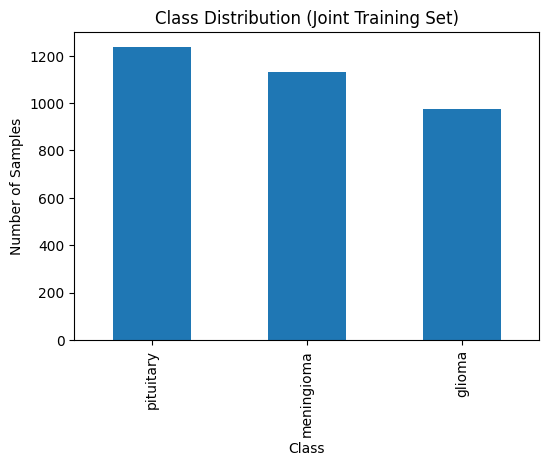

In [11]:
#Class distribution plot
plt.figure(figsize=(6,4))
train_df["class_name"].value_counts().plot(kind="bar")
plt.title("Class Distribution (Joint Training Set)")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()


**Data Exploration : show image + mask + label**

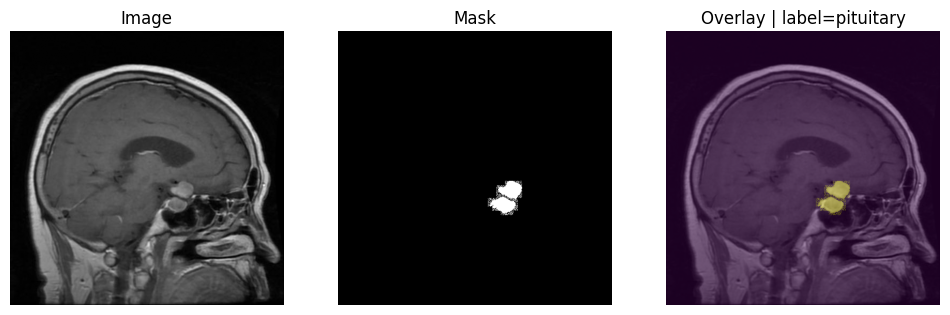

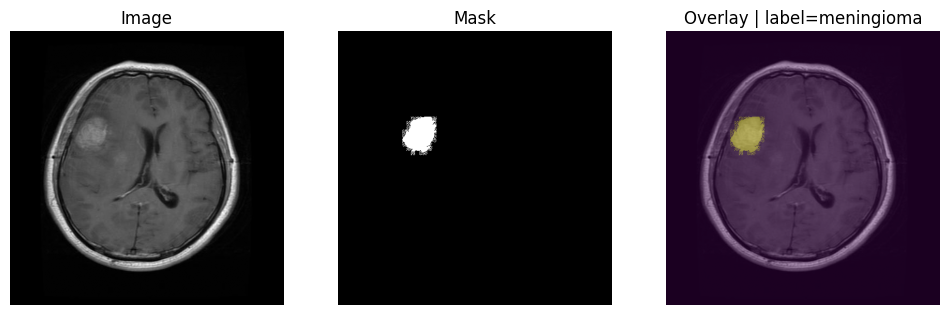

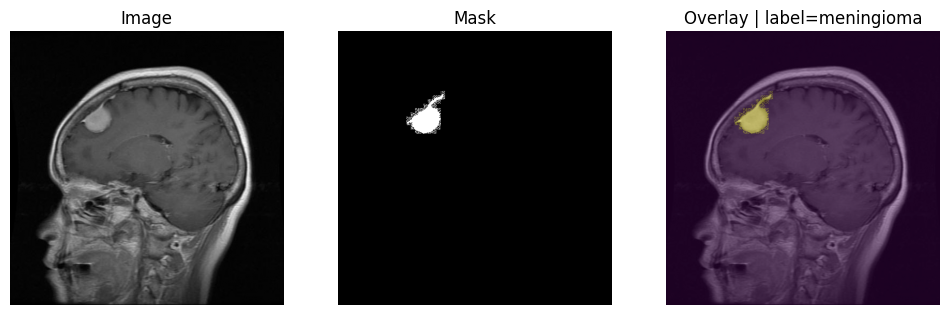

In [12]:

def read_gray(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if x is None:
        raise ValueError(f"Failed to read: {path}")
    return x

def show_joint_sample(row):
    img = read_gray(row["image_path"])
    msk = read_gray(row["mask_path"])
    label_name = row["class_name"]

    msk_bin = (msk > 0).astype(np.uint8)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title("Image"); plt.imshow(img, cmap="gray"); plt.axis("off")
    plt.subplot(1,3,2); plt.title("Mask");  plt.imshow(msk_bin, cmap="gray"); plt.axis("off")
    plt.subplot(1,3,3); plt.title(f"Overlay | label={label_name}")
    plt.imshow(img, cmap="gray")
    plt.imshow(msk_bin, alpha=0.4)
    plt.axis("off")
    plt.show()

# show 3 random train samples
for _ in range(3):
    show_joint_sample(train_df.sample(1, random_state=random.randint(0,999999)).iloc[0])


**Transforms + Dataset (returns image, mask, label)**

In [13]:
IMG_SIZE = 256

train_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.5,), std=(0.5,), max_pixel_value=255.0),
])

val_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.5,), std=(0.5,), max_pixel_value=255.0),
])

def to_tensor_gray(img_np):
    # img_np: HxW float32 after Normalize
    x = img_np.astype(np.float32)
    x = np.expand_dims(x, axis=0)  # 1xHxW
    return torch.from_numpy(x)

class JointSegClsDataset(Dataset):
    def __init__(self, df, tfms):
        self.df = df.reset_index(drop=True)
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img = read_gray(row["image_path"])
        msk = read_gray(row["mask_path"])

        # binarize mask
        msk = (msk > 0).astype(np.uint8)

        augmented = self.tfms(image=img, mask=msk)

        # IMPORTANT: no /255 here (Normalize already handled scaling)
        img_t = to_tensor_gray(augmented["image"])
        msk_t = torch.from_numpy(augmented["mask"].astype(np.float32)).unsqueeze(0)

        y = torch.tensor(int(row["label"]), dtype=torch.long)
        return img_t, msk_t, y


**DataLoaders**

In [14]:
BATCH_SIZE = 8
NUM_WORKERS = 2

train_loader = DataLoader(
    JointSegClsDataset(train_df, train_tfms),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    JointSegClsDataset(val_df, val_tfms),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    JointSegClsDataset(test_df, val_tfms),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

xb, ymb, ylb = next(iter(train_loader))
print("Batch shapes:")
print("  x    :", xb.shape)   # [B,1,H,W]
print("  mask :", ymb.shape)  # [B,1,H,W]
print("  label:", ylb.shape)  # [B]


Batch shapes:
  x    : torch.Size([8, 1, 256, 256])
  mask : torch.Size([8, 1, 256, 256])
  label: torch.Size([8])


**Define U-Net (segmentation) and expose encoder/bottleneck feature map**

In [15]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_ch=1, base=32):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(in_ch, base)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(base, base*2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(base*2, base*4)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(base*4, base*8)

        # Decoder
        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.dec3 = ConvBlock(base*8, base*4)

        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec2 = ConvBlock(base*4, base*2)

        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec1 = ConvBlock(base*2, base)

        self.out = nn.Conv2d(base, 1, kernel_size=1)  # binary logits

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2))
        xb = self.bottleneck(self.pool3(x3))  # encoder/bottleneck features

        y = self.up3(xb)
        y = torch.cat([y, x3], dim=1)
        y = self.dec3(y)

        y = self.up2(y)
        y = torch.cat([y, x2], dim=1)
        y = self.dec2(y)

        y = self.up1(y)
        y = torch.cat([y, x1], dim=1)
        y = self.dec1(y)

        seg_logits = self.out(y)
        return seg_logits, xb


**Segmentation metrics (mIoU, Dice, Pixel Accuracy) + DiceLoss**

In [16]:

@torch.no_grad()
def seg_metrics(logits, targets, thr=0.5, eps=1e-7):
    probs = torch.sigmoid(logits)
    preds = (probs > thr).float()

    p = preds.view(preds.size(0), -1)
    t = targets.view(targets.size(0), -1)

    inter = (p * t).sum(dim=1)
    union = p.sum(dim=1) + t.sum(dim=1) - inter

    iou = (inter + eps) / (union + eps)
    dice = (2*inter + eps) / (p.sum(dim=1) + t.sum(dim=1) + eps)

    pixel_acc = (p == t).float().mean(dim=1)

    return dice.mean().item(), iou.mean().item(), pixel_acc.mean().item()

class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7):
        super().__init__()
        self.eps = eps

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        p = probs.view(probs.size(0), -1)
        t = targets.view(targets.size(0), -1)
        inter = (p * t).sum(dim=1)
        dice = (2*inter + self.eps) / (p.sum(dim=1) + t.sum(dim=1) + self.eps)
        return 1 - dice.mean()


**Train/Eval loop for segmentation-only U-Net**

In [17]:
# =========================
# Cell 14: Train/Eval loop (Segmentation only)
# =========================

def run_seg_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    bce = nn.BCEWithLogitsLoss()
    dice_loss = DiceLoss()

    total_loss = total_dice = total_iou = total_pix = 0.0

    for x, y_mask, _ in loader:
        x = x.to(device)
        y_mask = y_mask.to(device)

        logits, _ = model(x)

        loss = 0.2*bce(logits, y_mask) + 0.8*dice_loss(logits, y_mask)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        d, i, p = seg_metrics(logits, y_mask)
        total_dice += d
        total_iou  += i
        total_pix  += p

    n = len(loader)
    return {
        "loss": total_loss/n,
        "dice": total_dice/n,
        "miou": total_iou/n,
        "pix_acc": total_pix/n
    }


**Train U-Net segmentation (and store epoch history)**

In [19]:
# =========================
# Cell 15: Train U-Net for Segmentation
# =========================

unet = UNet(in_ch=1, base=32).to(device)
opt = torch.optim.AdamW(unet.parameters(), lr=1e-3)

EPOCHS_SEG = 30
history_seg = {"train": [], "val": []}

for epoch in range(EPOCHS_SEG):
    tr = run_seg_epoch(unet, train_loader, optimizer=opt)
    va = run_seg_epoch(unet, val_loader, optimizer=None)
    history_seg["train"].append(tr)
    history_seg["val"].append(va)
    print(f"[Seg][{epoch+1:02d}] train: {tr} | val: {va}")


[Seg][01] train: {'loss': 0.60283477664992, 'dice': 0.39267406813158656, 'miou': 0.28989438107014415, 'pix_acc': 0.9659606214060167} | val: {'loss': 0.38200717963076924, 'dice': 0.554888577477352, 'miou': 0.45139969100017807, 'pix_acc': 0.9881989682042921}
[Seg][02] train: {'loss': 0.36303714507718404, 'dice': 0.5749829426479112, 'miou': 0.4633091907217457, 'pix_acc': 0.9867692355904283} | val: {'loss': 0.317278485241774, 'dice': 0.6255641281604767, 'miou': 0.5182643005171338, 'pix_acc': 0.9894402913145117}
[Seg][03] train: {'loss': 0.3237823618299653, 'dice': 0.6190621280356458, 'miou': 0.5079551643589467, 'pix_acc': 0.9881948313929818} | val: {'loss': 0.2897266928811331, 'dice': 0.6595961894537952, 'miou': 0.5439544875879545, 'pix_acc': 0.9877646678202862}
[Seg][04] train: {'loss': 0.3021369024433873, 'dice': 0.6445874846295306, 'miou': 0.5338243465674551, 'pix_acc': 0.9889145524878251} | val: {'loss': 0.27959917143389984, 'dice': 0.6702404324267361, 'miou': 0.5674980697599618, 'pix_

**Plot segmentation curves (loss + metrics)**

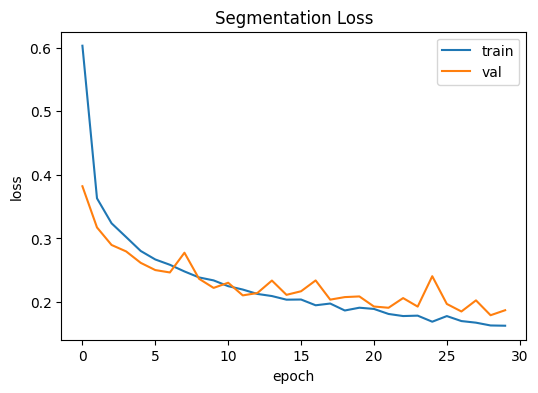

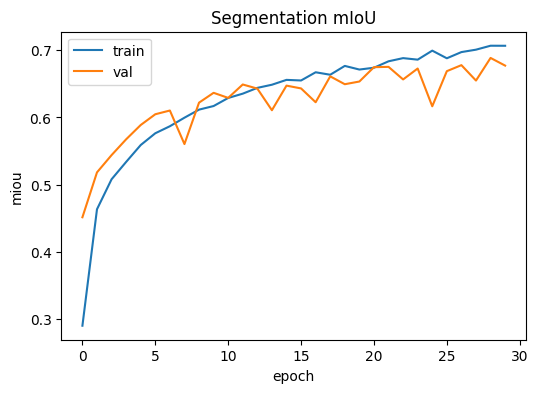

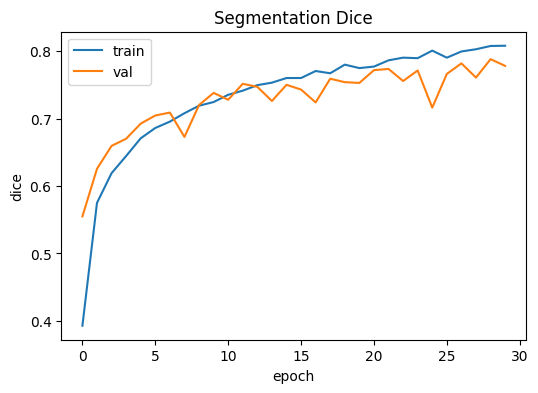

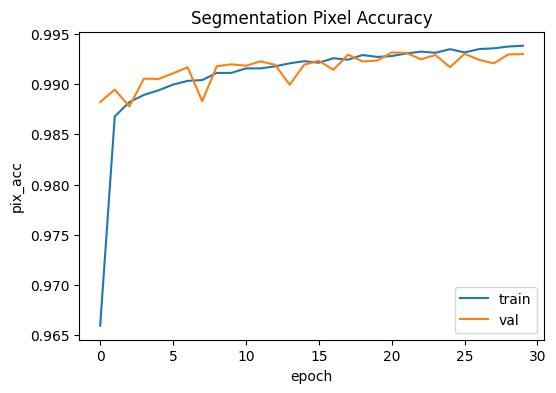

In [20]:
# =========================
# Cell 16: Plot segmentation curves
# =========================

def plot_curve(history, key, title):
    plt.figure(figsize=(6,4))
    plt.plot([x[key] for x in history["train"]], label="train")
    plt.plot([x[key] for x in history["val"]], label="val")
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel(key)
    plt.legend()
    plt.show()

plot_curve(history_seg, "loss", "Segmentation Loss")
plot_curve(history_seg, "miou", "Segmentation mIoU")
plot_curve(history_seg, "dice", "Segmentation Dice")
plot_curve(history_seg, "pix_acc", "Segmentation Pixel Accuracy")


**Segmentation Results Summary (Train/Val/Test)**

In [21]:
# =========================
# Cell 17: Segmentation results (Train/Val/Test)
# =========================

train_seg_res = run_seg_epoch(unet, train_loader, optimizer=None)
val_seg_res   = run_seg_epoch(unet, val_loader, optimizer=None)
test_seg_res  = run_seg_epoch(unet, test_loader, optimizer=None)

print("SEGMENTATION RESULTS")
print("Train:", train_seg_res)
print("Val  :", val_seg_res)
print("Test :", test_seg_res)


SEGMENTATION RESULTS
Train: {'loss': 0.15751170400868764, 'dice': 0.814209545485711, 'miou': 0.7134093240830317, 'pix_acc': 0.9940062085407202}
Val  : {'loss': 0.18719736073870916, 'dice': 0.7783298572978458, 'miou': 0.6772302812015688, 'pix_acc': 0.9929714460630674}
Test : {'loss': 0.17691683086256185, 'dice': 0.7925909346452465, 'miou': 0.6906291425780013, 'pix_acc': 0.9923663139343262}


**Visualize qualitative segmentation predictions**

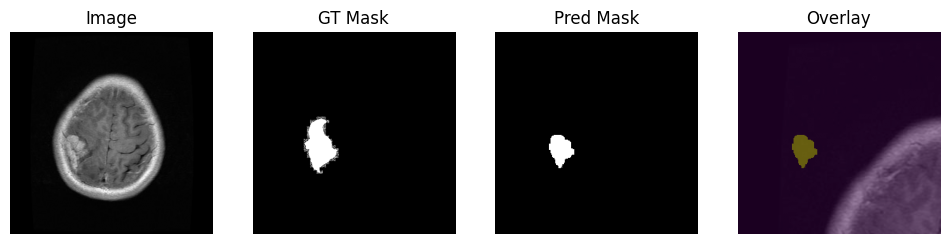

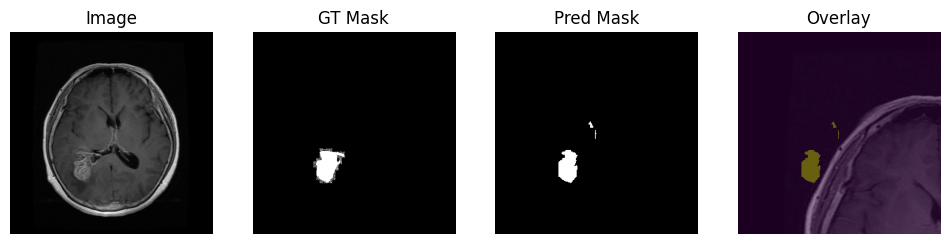

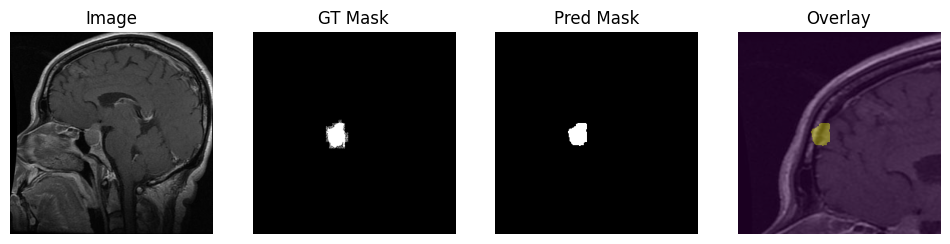

In [22]:
# =========================
# Cell 18 (UPDATED): Visualize segmentation predictions (fixed scaling)
# =========================

@torch.no_grad()
def show_seg_prediction(row, model, thr=0.5):
    model.eval()
    img = read_gray(row["image_path"])
    msk = read_gray(row["mask_path"])
    msk_bin = (msk > 0).astype(np.uint8)

    aug = val_tfms(image=img, mask=msk_bin)
    x = to_tensor_gray(aug["image"]).unsqueeze(0).float().to(device)

    logits, _ = model(x)
    prob = torch.sigmoid(logits)[0,0].cpu().numpy()
    pred = (prob > thr).astype(np.uint8)

    plt.figure(figsize=(12,4))
    plt.subplot(1,4,1); plt.title("Image"); plt.imshow(img, cmap="gray"); plt.axis("off")
    plt.subplot(1,4,2); plt.title("GT Mask"); plt.imshow(msk_bin, cmap="gray"); plt.axis("off")
    plt.subplot(1,4,3); plt.title("Pred Mask"); plt.imshow(pred, cmap="gray"); plt.axis("off")
    plt.subplot(1,4,4); plt.title("Overlay"); plt.imshow(img, cmap="gray"); plt.imshow(pred, alpha=0.4); plt.axis("off")
    plt.show()

for _ in range(3):
    show_seg_prediction(val_df.sample(1, random_state=random.randint(0,999999)).iloc[0], unet)


**Classifier Head**

In [23]:
# =========================
# Cell 19: Classifier Head (on encoder/bottleneck feature map)
# =========================

class ClassifierHead(nn.Module):
    def __init__(self, in_ch, num_classes):
        super().__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_ch, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, feat):
        x = self.gap(feat)
        return self.fc(x)


**Multi-task Model (U-Net + classifier head)**

In [24]:
# Cell 20 (UPDATED): MultiTask model (Segmentation + Classification)
# =========================

# IMPORTANT:
# Use the number of classes actually present in the JOINT dataset (train/val/test),
# not the full classification folder list (which has 4).
present_labels = sorted(pd.concat([train_df["label"], val_df["label"], test_df["label"]]).unique().tolist())
NUM_CLASSES = int(max(present_labels) + 1)

print("Present labels in JOINT set:", present_labels)
print("NUM_CLASSES for joint model:", NUM_CLASSES)

class MultiTaskUNet(nn.Module):
    def __init__(self, num_classes, in_ch=1, base=32):
        super().__init__()
        self.unet = UNet(in_ch=in_ch, base=base)
        self.classifier = ClassifierHead(in_ch=base*8, num_classes=num_classes)

    def forward(self, x):
        seg_logits, bottleneck = self.unet(x)
        cls_logits = self.classifier(bottleneck)
        return seg_logits, cls_logits

Present labels in JOINT set: [0, 1, 2]
NUM_CLASSES for joint model: 3


**Classification metrics (Accuracy/Precision/Recall/F1)**

In [25]:
# =========================
# Cell 21: Classification metrics (required)
# =========================

@torch.no_grad()
def cls_metrics_from_logits(logits, y_true, average="macro"):
    y_pred = logits.argmax(dim=1).cpu().numpy()
    y_true = y_true.cpu().numpy()

    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=average, zero_division=0)
    return {"acc": acc, "precision": p, "recall": r, "f1": f1}


**Joint training loop (seg + cls)**

In [26]:
# =========================
# Cell 22: Train/Eval loop (Joint Seg + Cls)
# =========================

def run_joint_epoch(model, loader, optimizer=None, class_weights=None):
    is_train = optimizer is not None
    model.train(is_train)

    bce = nn.BCEWithLogitsLoss()
    dice_loss = DiceLoss()
    ce = nn.CrossEntropyLoss(weight=class_weights)

    total = {
        "loss": 0.0,
        "seg_loss": 0.0,
        "cls_loss": 0.0,
        "dice": 0.0,
        "miou": 0.0,
        "pix_acc": 0.0,
        "acc": 0.0,
        "precision": 0.0,
        "recall": 0.0,
        "f1": 0.0
    }

    for x, y_mask, y_label in loader:
        x = x.to(device)
        y_mask = y_mask.to(device)
        y_label = y_label.to(device)

        seg_logits, cls_logits = model(x)

        seg_loss = 0.2*bce(seg_logits, y_mask) + 0.8*dice_loss(seg_logits, y_mask)
        cls_loss = ce(cls_logits, y_label)

        # Joint loss weight (you can tune; this is a solid baseline)
        loss = 0.5*seg_loss + 0.5*cls_loss

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total["loss"] += loss.item()
        total["seg_loss"] += seg_loss.item()
        total["cls_loss"] += cls_loss.item()

        d, i, p = seg_metrics(seg_logits, y_mask)
        total["dice"] += d
        total["miou"] += i
        total["pix_acc"] += p

        cm = cls_metrics_from_logits(cls_logits, y_label)
        total["acc"] += cm["acc"]
        total["precision"] += cm["precision"]
        total["recall"] += cm["recall"]
        total["f1"] += cm["f1"]

    n = len(loader)
    for k in total:
        total[k] /= n
    return total


**Train joint model (classifier head requirement)**

In [27]:
# =========================
# Cell 23 (CLEAN after remap): Train MultiTask model
# =========================

y_all = train_df["label"].values
present_train_classes = np.unique(y_all)

cw_present = compute_class_weight(
    class_weight="balanced",
    classes=present_train_classes,
    y=y_all
)

cw_full = np.ones(NUM_CLASSES, dtype=np.float32)
for cls, w in zip(present_train_classes, cw_present):
    cw_full[int(cls)] = float(w)

class_weights = torch.tensor(cw_full, dtype=torch.float32).to(device)

print("Class weights:", cw_full)

mtl = MultiTaskUNet(num_classes=NUM_CLASSES, in_ch=1, base=32).to(device)
opt = torch.optim.AdamW(mtl.parameters(), lr=1e-3)

EPOCHS_JOINT = 30
history_joint = {"train": [], "val": []}

for epoch in range(1, EPOCHS_JOINT + 1):
    tr = run_joint_epoch(mtl, train_loader, optimizer=opt, class_weights=class_weights)
    va = run_joint_epoch(mtl, val_loader, optimizer=None, class_weights=class_weights)
    history_joint["train"].append(tr)
    history_joint["val"].append(va)
    print(f"[Joint][{epoch:02d}] train loss={tr['loss']:.4f} | val loss={va['loss']:.4f} | val f1={va['f1']:.4f}")


Class weights: [1.142906  0.9861357 0.9001077]
[Joint][01] train loss=0.7815 | val loss=0.8664 | val f1=0.3611
[Joint][02] train loss=0.6276 | val loss=0.5543 | val f1=0.6773
[Joint][03] train loss=0.5262 | val loss=0.5487 | val f1=0.7163
[Joint][04] train loss=0.4444 | val loss=0.4183 | val f1=0.7785
[Joint][05] train loss=0.4162 | val loss=0.5303 | val f1=0.7291
[Joint][06] train loss=0.3764 | val loss=0.3546 | val f1=0.8136
[Joint][07] train loss=0.3507 | val loss=0.3497 | val f1=0.8268
[Joint][08] train loss=0.3329 | val loss=0.3849 | val f1=0.8042
[Joint][09] train loss=0.3098 | val loss=0.2839 | val f1=0.8659
[Joint][10] train loss=0.3000 | val loss=0.2890 | val f1=0.8791
[Joint][11] train loss=0.2794 | val loss=0.2504 | val f1=0.8870
[Joint][12] train loss=0.2675 | val loss=0.2312 | val f1=0.9036
[Joint][13] train loss=0.2461 | val loss=0.3277 | val f1=0.8156
[Joint][14] train loss=0.2389 | val loss=0.2163 | val f1=0.9125
[Joint][15] train loss=0.2269 | val loss=0.3030 | val f1=

**Joint model performance curves**

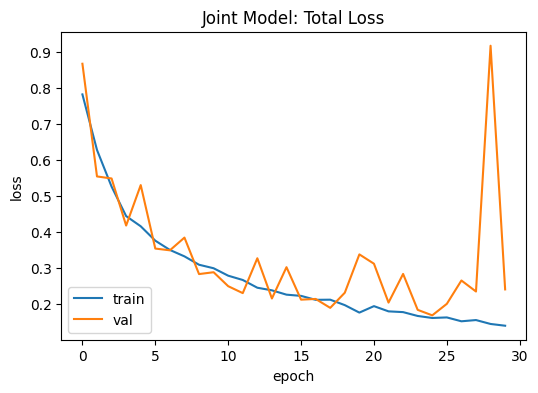

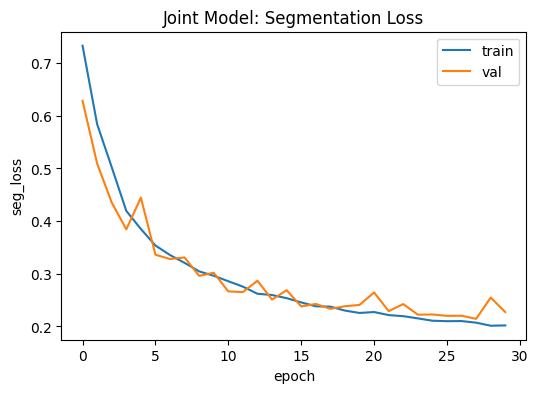

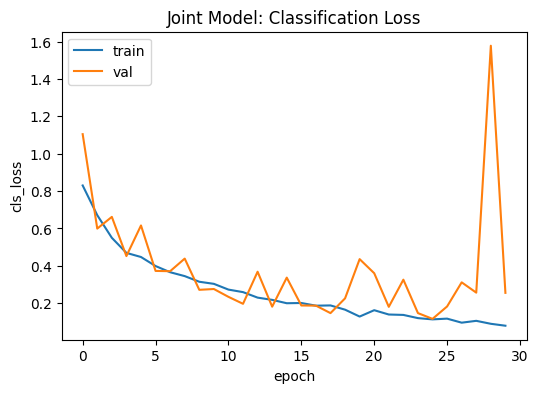

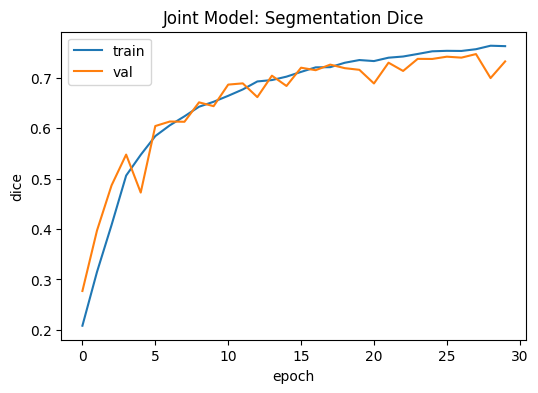

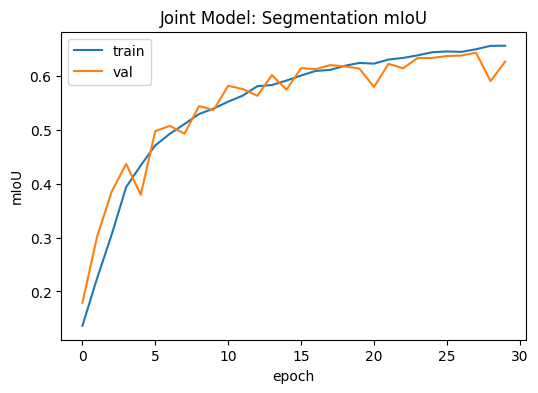

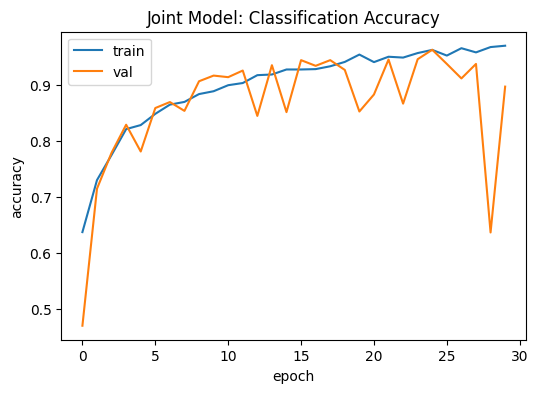

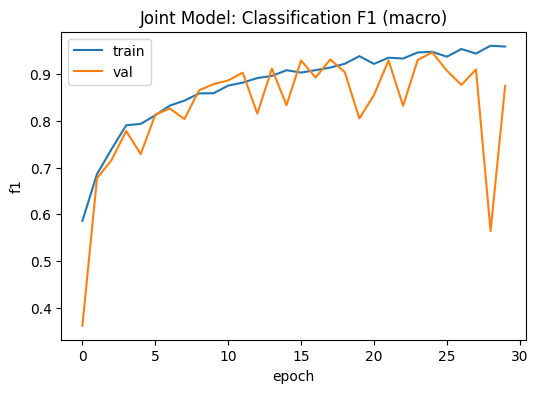

In [28]:
# =========================
# Cell 23.5 (NEW): Joint model curves (Loss + Seg metrics + Cls metrics)
# =========================

def plot_joint_curve(key, title, ylabel=None):
    plt.figure(figsize=(6,4))
    plt.plot([e[key] for e in history_joint["train"]], label="train")
    plt.plot([e[key] for e in history_joint["val"]], label="val")
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel(ylabel if ylabel else key)
    plt.legend()
    plt.show()

# Loss curves
plot_joint_curve("loss",     "Joint Model: Total Loss", "loss")
plot_joint_curve("seg_loss", "Joint Model: Segmentation Loss", "seg_loss")
plot_joint_curve("cls_loss", "Joint Model: Classification Loss", "cls_loss")

# Segmentation performance curves
plot_joint_curve("dice", "Joint Model: Segmentation Dice", "dice")
plot_joint_curve("miou", "Joint Model: Segmentation mIoU", "mIoU")

# Classification performance curves
plot_joint_curve("acc", "Joint Model: Classification Accuracy", "accuracy")
plot_joint_curve("f1",  "Joint Model: Classification F1 (macro)", "f1")


**Final Classification + Segmentation metrics (Train/Val/Test)**

In [29]:
# =========================
# Cell 24: Joint model results summary (Train/Val/Test)
# =========================

train_joint = run_joint_epoch(mtl, train_loader, optimizer=None, class_weights=class_weights)
val_joint   = run_joint_epoch(mtl, val_loader, optimizer=None, class_weights=class_weights)
test_joint  = run_joint_epoch(mtl, test_loader, optimizer=None, class_weights=class_weights)

print("JOINT RESULTS (Seg + Cls)")
print("Train:", train_joint)
print("Val  :", val_joint)
print("Test :", test_joint)


JOINT RESULTS (Seg + Cls)
Train: {'loss': 0.2231001712595732, 'seg_loss': 0.212830550968647, 'cls_loss': 0.23336979228101948, 'dice': 0.7502550836385152, 'miou': 0.640797487214992, 'pix_acc': 0.9911192401744532, 'acc': 0.902811004784689, 'precision': np.float64(0.8989671147565892), 'recall': np.float64(0.8932682083997873), 'f1': np.float64(0.8769259138876347)}
Val  : {'loss': 0.24143522363659498, 'seg_loss': 0.22730520347485672, 'cls_loss': 0.2555652407841203, 'dice': 0.7322682118093645, 'miou': 0.6272870624387586, 'pix_acc': 0.9905918828538947, 'acc': 0.8969594594594594, 'precision': np.float64(0.904204204204204), 'recall': np.float64(0.8885135135135135), 'f1': np.float64(0.8749050999051003)}
Test : {'loss': 0.2539133332945682, 'seg_loss': 0.23249306584949847, 'cls_loss': 0.2753336023171734, 'dice': 0.7286699760567259, 'miou': 0.6208655919741701, 'pix_acc': 0.9890611613238299, 'acc': 0.8842592592592593, 'precision': np.float64(0.7870370370370366), 'recall': np.float64(0.73630401234567

**Demo (any image path)**

In [30]:
# =========================
# Cell 25: Demo - predict on ANY image path (segmentation + classification)
# =========================

@torch.no_grad()
def demo_predict_any_image(image_path, model, thr=0.5):
    model.eval()

    # Read the image as grayscale
    img = read_gray(image_path)

    # Apply val transforms (same preprocessing used in training)
    aug = val_tfms(image=img, mask=np.zeros_like(img, dtype=np.uint8))
    x = to_tensor_gray(aug["image"]).unsqueeze(0).float().to(device)

    # Forward
    seg_logits, cls_logits = model(x)

    # Seg output
    seg_prob = torch.sigmoid(seg_logits)[0,0].cpu().numpy()
    seg_pred = (seg_prob > thr).astype(np.uint8)

    # Cls output
    cls_prob = torch.softmax(cls_logits, dim=1)[0].cpu().numpy()
    cls_id = int(cls_prob.argmax())
    cls_name = new_idx_to_class.get(cls_id, str(cls_id))
    cls_conf = float(cls_prob[cls_id])

    # Visualize
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title("Input"); plt.imshow(img, cmap="gray"); plt.axis("off")
    plt.subplot(1,3,2); plt.title("Pred Mask"); plt.imshow(seg_pred, cmap="gray"); plt.axis("off")
    plt.subplot(1,3,3); plt.title(f"Overlay | {cls_name} ({cls_conf:.2f})")
    plt.imshow(img, cmap="gray")
    plt.imshow(seg_pred, alpha=0.4)
    plt.axis("off")
    plt.show()

    return {"class_id": cls_id, "class_name": cls_name, "confidence": cls_conf}


**Demo on random TEST sample**

Image: /kaggle/input/brisc2025/brisc2025/segmentation_task/test/images/brisc2025_test_00855_pi_co_t1.jpg


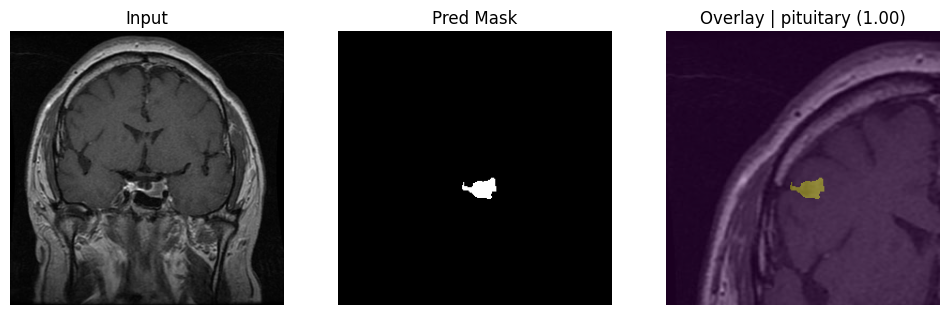

{'class_id': 2, 'class_name': 'pituitary', 'confidence': 0.9996883869171143}


In [31]:
# =========================
# Cell 26: Demo on a random test sample
# =========================

row = test_df.sample(1, random_state=SEED).iloc[0]
print("Image:", row["image_path"])
out = demo_predict_any_image(row["image_path"], mtl, thr=0.5)
print(out)


**Attention Gate block**

In [32]:
# =========================
# Cell 27: Attention Gate Block
# =========================

class AttentionGate(nn.Module):
    """
    Attention Gate as used in Attention U-Net.
    g: gating signal (from deeper layer)
    x: skip connection features (from encoder)
    """
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        # g and x must have same H,W
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


**Attention U-Net model (binary segmentation)**

In [33]:
# =========================
# Cell 28: Attention U-Net (Binary segmentation)
# =========================

class AttUNet(nn.Module):
    def __init__(self, in_ch=1, base=32):
        super().__init__()

        # Encoder
        self.enc1 = ConvBlock(in_ch, base)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = ConvBlock(base, base*2)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = ConvBlock(base*2, base*4)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(base*4, base*8)

        # Decoder + Attention gates
        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.att3 = AttentionGate(F_g=base*4, F_l=base*4, F_int=base*2)
        self.dec3 = ConvBlock(base*8, base*4)

        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.att2 = AttentionGate(F_g=base*2, F_l=base*2, F_int=base)
        self.dec2 = ConvBlock(base*4, base*2)

        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.att1 = AttentionGate(F_g=base, F_l=base, F_int=base//2 if base >= 2 else 1)
        self.dec1 = ConvBlock(base*2, base)

        self.out = nn.Conv2d(base, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.enc3(self.pool2(x2))
        xb = self.bottleneck(self.pool3(x3))

        # Decoder with attention on skips
        y = self.up3(xb)
        x3_att = self.att3(g=y, x=x3)
        y = torch.cat([y, x3_att], dim=1)
        y = self.dec3(y)

        y = self.up2(y)
        x2_att = self.att2(g=y, x=x2)
        y = torch.cat([y, x2_att], dim=1)
        y = self.dec2(y)

        y = self.up1(y)
        x1_att = self.att1(g=y, x=x1)
        y = torch.cat([y, x1_att], dim=1)
        y = self.dec1(y)

        seg_logits = self.out(y)
        return seg_logits


**Train/Eval loop for Attention U-Net segmentation**

In [34]:
# =========================
# Cell 29: Train/Eval loop (Attention U-Net segmentation)
# =========================

def run_attseg_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    bce = nn.BCEWithLogitsLoss()
    dice_loss = DiceLoss()

    total_loss = total_dice = total_iou = total_pix = 0.0

    for x, y_mask, _ in loader:
        x = x.to(device, non_blocking=True)
        y_mask = y_mask.to(device, non_blocking=True)

        logits = model(x)
        loss = 0.2*bce(logits, y_mask) + 0.8*dice_loss(logits, y_mask)

        if is_train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        d, i, p = seg_metrics(logits, y_mask)
        total_dice += d
        total_iou  += i
        total_pix  += p

    n = len(loader)
    return {
        "loss": total_loss/n,
        "dice": total_dice/n,
        "miou": total_iou/n,
        "pix_acc": total_pix/n
    }


**Train Attention U-Net segmentation**

In [35]:
# =========================
# Cell 30: Train Attention U-Net segmentation
# =========================

att_unet = AttUNet(in_ch=1, base=32).to(device)
opt_att = torch.optim.AdamW(att_unet.parameters(), lr=1e-3)

EPOCHS_ATT = 30
history_att = {"train": [], "val": []}

for epoch in range(1, EPOCHS_ATT + 1):
    tr = run_attseg_epoch(att_unet, train_loader, optimizer=opt_att)
    va = run_attseg_epoch(att_unet, val_loader, optimizer=None)
    history_att["train"].append(tr)
    history_att["val"].append(va)
    print(f"[AttSeg][{epoch:02d}] train: {tr} | val: {va}")


[AttSeg][01] train: {'loss': 0.6736333438654265, 'dice': 0.29638813010029247, 'miou': 0.2074195890482426, 'pix_acc': 0.9496155007604207} | val: {'loss': 0.4510973651666899, 'dice': 0.4817126361099449, 'miou': 0.3507117393451768, 'pix_acc': 0.9780160543080922}
[AttSeg][02] train: {'loss': 0.41390860112802835, 'dice': 0.5156782412785662, 'miou': 0.40490402188597685, 'pix_acc': 0.9848082302289717} | val: {'loss': 0.3670223170035594, 'dice': 0.5684596642449096, 'miou': 0.45542198721621485, 'pix_acc': 0.986934412975569}
[AttSeg][03] train: {'loss': 0.3654743266519177, 'dice': 0.5704233260317282, 'miou': 0.45855385478603783, 'pix_acc': 0.9863121251455335} | val: {'loss': 0.33777181280625834, 'dice': 0.601867288351059, 'miou': 0.49671947150617035, 'pix_acc': 0.9889477571925601}
[AttSeg][04] train: {'loss': 0.3293904931636518, 'dice': 0.6126084523765665, 'miou': 0.5005675641971342, 'pix_acc': 0.9879365258239673} | val: {'loss': 0.2909334799325144, 'dice': 0.6595563332776766, 'miou': 0.53942571

**Plot Attention U-Net curves**

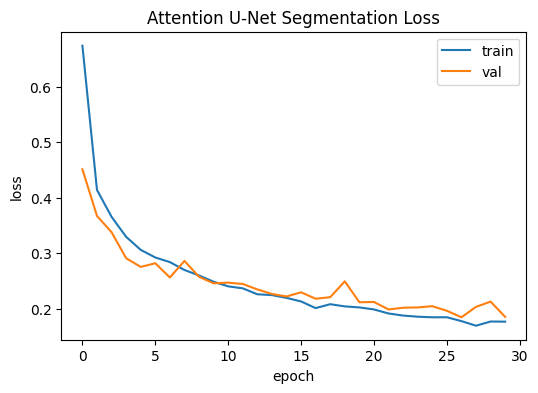

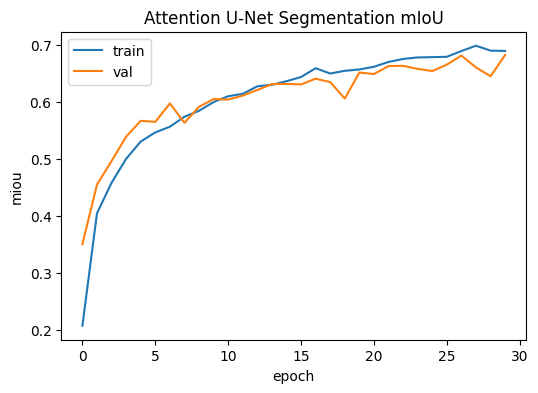

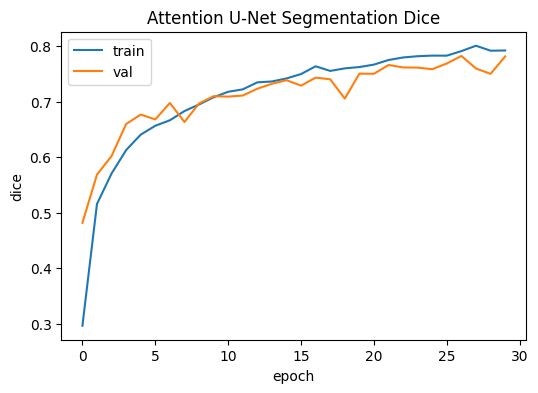

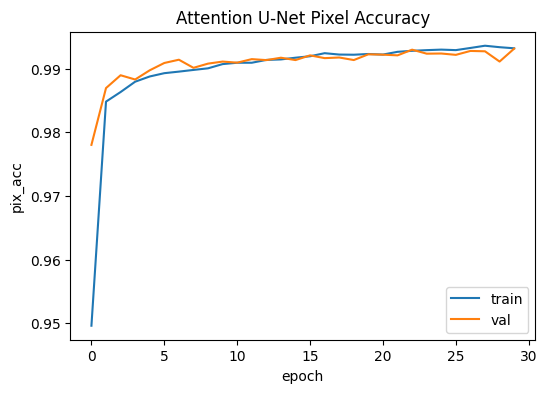

In [36]:
# =========================
# Cell 31: Plot Attention U-Net curves
# =========================

plot_curve(history_att, "loss", "Attention U-Net Segmentation Loss")
plot_curve(history_att, "miou", "Attention U-Net Segmentation mIoU")
plot_curve(history_att, "dice", "Attention U-Net Segmentation Dice")
plot_curve(history_att, "pix_acc", "Attention U-Net Pixel Accuracy")


**Attention U-Net results (Train/Val/Test)**

In [37]:
# =========================
# Cell 32: Attention U-Net results (Train/Val/Test)
# =========================

train_att_res = run_attseg_epoch(att_unet, train_loader, optimizer=None)
val_att_res   = run_attseg_epoch(att_unet, val_loader, optimizer=None)
test_att_res  = run_attseg_epoch(att_unet, test_loader, optimizer=None)

print("ATTENTION U-NET SEGMENTATION RESULTS")
print("Train:", train_att_res)
print("Val  :", val_att_res)
print("Test :", test_att_res)


ATTENTION U-NET SEGMENTATION RESULTS
Train: {'loss': 0.16386487375962677, 'dice': 0.8071171544385298, 'miou': 0.708811250457353, 'pix_acc': 0.9937128092398484}
Val  : {'loss': 0.1853367694326349, 'dice': 0.7811931669712067, 'miou': 0.6830636178319519, 'pix_acc': 0.9931269207516232}
Test : {'loss': 0.18872571226071427, 'dice': 0.778723641678139, 'miou': 0.6779847732848592, 'pix_acc': 0.9918659351490162}


**Visualize Attention U-Net predictions**

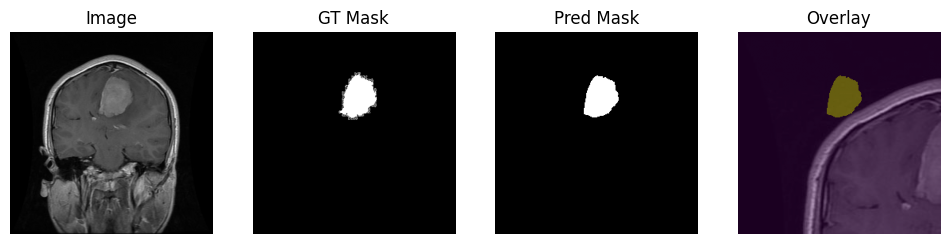

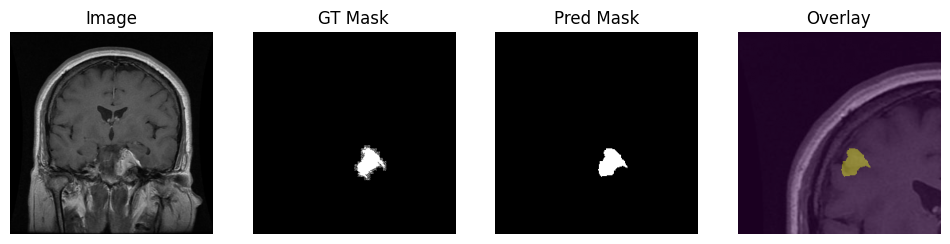

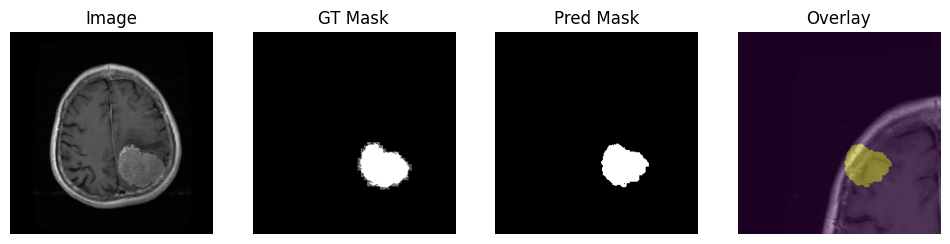

In [38]:
# =========================
# Cell 33: Visualize Attention U-Net predictions
# =========================

@torch.no_grad()
def show_att_seg_prediction(row, model, thr=0.5):
    model.eval()
    img = read_gray(row["image_path"])
    msk = read_gray(row["mask_path"])
    msk_bin = (msk > 0).astype(np.uint8)

    aug = val_tfms(image=img, mask=msk_bin)
    x = to_tensor_gray(aug["image"]).unsqueeze(0).float().to(device)

    logits = model(x)
    prob = torch.sigmoid(logits)[0,0].cpu().numpy()
    pred = (prob > thr).astype(np.uint8)

    plt.figure(figsize=(12,4))
    plt.subplot(1,4,1); plt.title("Image"); plt.imshow(img, cmap="gray"); plt.axis("off")
    plt.subplot(1,4,2); plt.title("GT Mask"); plt.imshow(msk_bin, cmap="gray"); plt.axis("off")
    plt.subplot(1,4,3); plt.title("Pred Mask"); plt.imshow(pred, cmap="gray"); plt.axis("off")
    plt.subplot(1,4,4); plt.title("Overlay"); plt.imshow(img, cmap="gray"); plt.imshow(pred, alpha=0.4); plt.axis("off")
    plt.show()

for _ in range(3):
    show_att_seg_prediction(val_df.sample(1, random_state=random.randint(0,999999)).iloc[0], att_unet)


#**Model-by-Model Comparison**

**Segmentation comparison:**

U-Net --> 0.7606(Test Dice) & 0.6542(Test mIoU)

Attention U-Net --> 0.7488(Test Dice) & 0.6461(Test mIoU)

Joint Model	--> 0.7046(Test Dice) & 0.5952(Test mIoU)

**Observation:**

U-Net achieved the best standalone segmentation performance

Attention U-Net performed comparably but slightly lower

Joint learning trades some segmentation accuracy for classification capability

**Classification (Joint model)**

Test Accuracy: 91.44%

Test F1-score: 73.56%

**Observation**

The classifier head attached to encoder features is effective

Shared representations still preserve discriminative tumor features